In [23]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
import pandas as pd
import copy
import cartopy.crs as ccrs
from sklearn.neighbors import kneighbors_graph
import itertools
from geopy import distance
import cartopy.feature as cfeature
from scipy.signal import butter, filtfilt
from astropy.convolution import convolve, Gaussian2DKernel, convolve_fft
from sklearn.metrics.pairwise import haversine_distances

from math import radians

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.colors import ListedColormap
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import xesmf as xe

### INputs

In [131]:
saved_distance_matrix_bool = False
saved_distance_matrix_file_path = 'na'

#wet_path = '/work/t1a/AVISO_global_1993to2023_sla_monthly'
file_path_zos_aviso = '/work/jet/sea_level_covariability/data/zarr/AVISO_global_1994to2020_zos_monthly/'
file_path = '/work/jet/sea_level_covariability/data/zarr/CM4_historical_251_global_1850to2014_zos_monthly'

start_year, end_year = 1993, 2015

smoothing_std = 20

longitude_min, longitude_max = 0, 360
latitude_min, latitude_max = -62.5, 67.5

coarsen_factor_longitude, coarsen_factor_latitude = 20, 20

#rolling_window_ar = [12]
rolling_window = 12

a_const_dist_matrix = (2*46.51927**2)

num_clusters_arr_silo = np.arange(2,50)

num_clusters_arr = np.arange(6, 15)
num_clusters = 6
linkage_type = 'average'
linkage_ar = ['average', 'ward', 'complete', 'single']
geographic_distance, saved_geo_matrix_bool = '/work/t1a/geographic_distance_matrix_5x5_20_rolling_5.npy', False

### AHCA Clustering

In [88]:
ds = xr.open_zarr(file_path)
ds = ds.rename({'xh': 'longitude', 'yh': 'latitude'})
subset = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
subset.load()
ds_aviso = xr.open_zarr(file_path_zos_aviso)
ds_aviso = ds_aviso.rename({'xh': 'longitude', 'yh': 'latitude'})

regridder = xe.Regridder(ds, ds_aviso, "bilinear")
ds_regridded = regridder(subset)

mask = ds_aviso['zos'].isel(time=-14).isnull()

In [91]:
subset_masked_cm4 = ds_regridded.where(~mask).copy(deep=True)
subset_masked_cm4.load()

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 720, longitude: 1440, time: 264)
Coordinates:
    geolat     (latitude, longitude) float64 8MB -89.88 -89.88 ... 89.88 89.88
    geolon     (latitude, longitude) float64 8MB -179.9 -179.6 ... 179.6 179.9
  * time       (time) object 2kB 1993-01-16 12:00:00 ... 2014-12-16 12:00:00
  * longitude  (longitude) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude   (latitude) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Data variables:
    areacello  (latitude, longitude) float32 4MB nan nan nan nan ... nan nan nan
    deptho     (latitude, longitude) float32 4MB nan nan nan nan ... nan nan nan
    wet        (latitude, longitude) float32 4MB nan nan nan nan ... nan nan nan
    zos        (time, latitude, longitude) float32 1GB nan nan nan ... nan nan
Attributes:
    regrid_method:  bilinear

In [123]:
kernel = Gaussian2DKernel(x_stddev=smoothing_std)
# we then smooth every time, spatially

for count, time_val in enumerate(subset_masked_cm4.zos.time):
    single_day_smoove = convolve_fft((subset_masked_cm4.zos.isel(time=count)), kernel)
    back_to_da = xr.DataArray(single_day_smoove, dims=("latitude", "longitude"))
    back_to_da = back_to_da.assign_coords(latitude=subset_masked_cm4.latitude, longitude=subset_masked_cm4.longitude)
    subset_masked_cm4['zos'][count] = back_to_da
    print(count)

    # Coarsen data, change boundaries, and mask the dry values #####################################################################
subset_Coarse = subset_masked_cm4.coarsen(longitude=coarsen_factor_longitude, latitude=coarsen_factor_latitude, boundary='pad').mean().copy(deep=True)

subset_Coarse_lat_lon_slice = subset_Coarse.copy(deep=True)
subset_Coarse_lat_lon_slice['wet'] = subset_Coarse_lat_lon_slice['wet'].round()
mask = subset_Coarse_lat_lon_slice['wet'] == 1

subset_Coarse_lat_lon_slice = subset_Coarse.where(mask)

# Low pass filter code Here (i.e. temporal smoothing)  #######################################################################
subset_Coarse_lat_lon_slice_initeration = subset_Coarse_lat_lon_slice.zos.rolling(time=rolling_window, center=True).mean().copy(deep=True)

# Keys for indexing in the dataframe ###################################################################################

ds_subset = subset_Coarse_lat_lon_slice_initeration.to_dataframe()
ds_dataframe_nonnan = ds_subset.dropna()

grouped_df = ds_dataframe_nonnan.groupby(['latitude', 'longitude'])
grouped_by_longitude_latitude = grouped_df.groups
keys_for_indexing = list(grouped_by_longitude_latitude.keys())

# Distance matrix ################################################################################################################## 

n = len(grouped_by_longitude_latitude)
comparison_matrix = np.zeros((n, n), dtype=float)


geographic_matrix = (haversine_distances(np.radians(keys_for_indexing)) * 6371)
da_flat = subset_Coarse_lat_lon_slice_initeration.stack(location=('latitude', 'longitude')).transpose('location', 'time')
da_flattened = da_flat.dropna(dim='location', how='all')
r = da_flattened.to_pandas().T.corr(method='pearson')

comparison_matrix = 1-np.exp((-geographic_matrix)/(a_const_dist_matrix))*r

nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
nan_dataset_to_fill['zos'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['zos'].coords, 
                            dims=nan_dataset_to_fill['zos'].dims)
nan_dataset_to_fill = nan_dataset_to_fill.mean(dim='time')

/vftmp/Theo.Avila/pid4345/ipykernel_41731/1786868688.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid4345/ipykernel_41731/1786868688.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid4345/ipykernel_41731/1786868688.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid4345/ipykernel_41731/1786868688.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/T

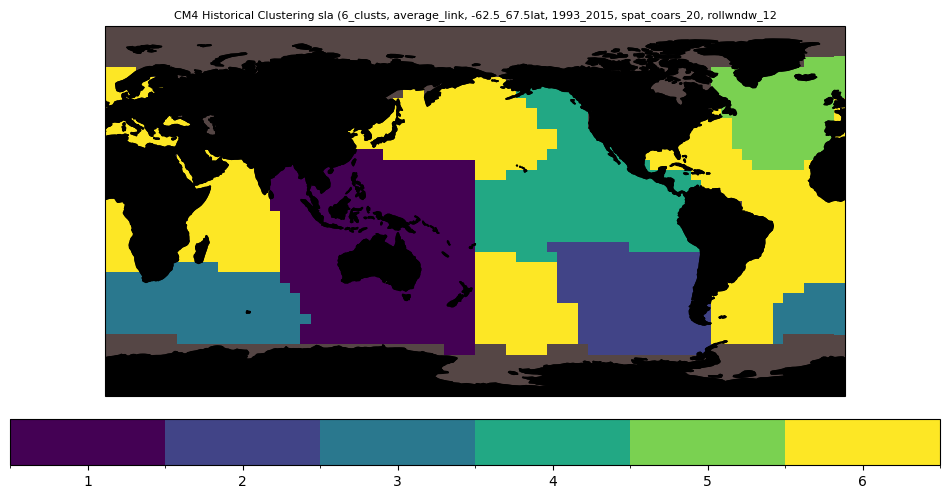

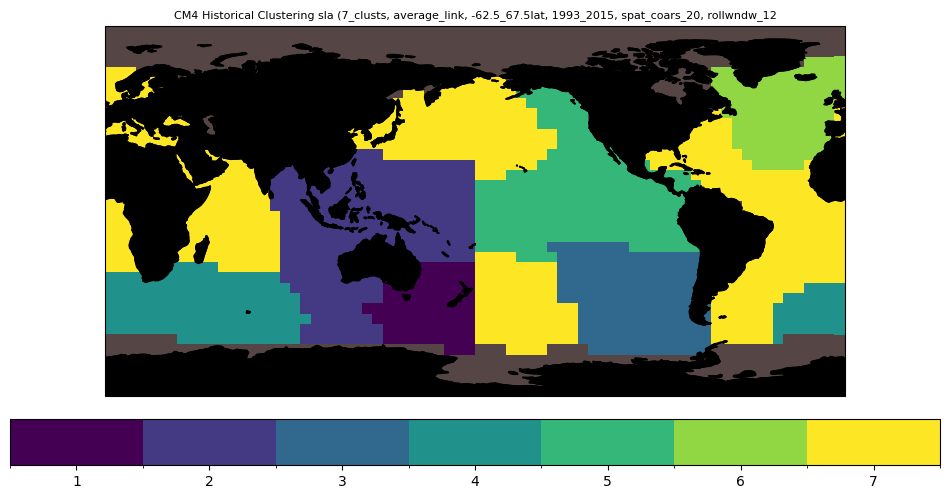

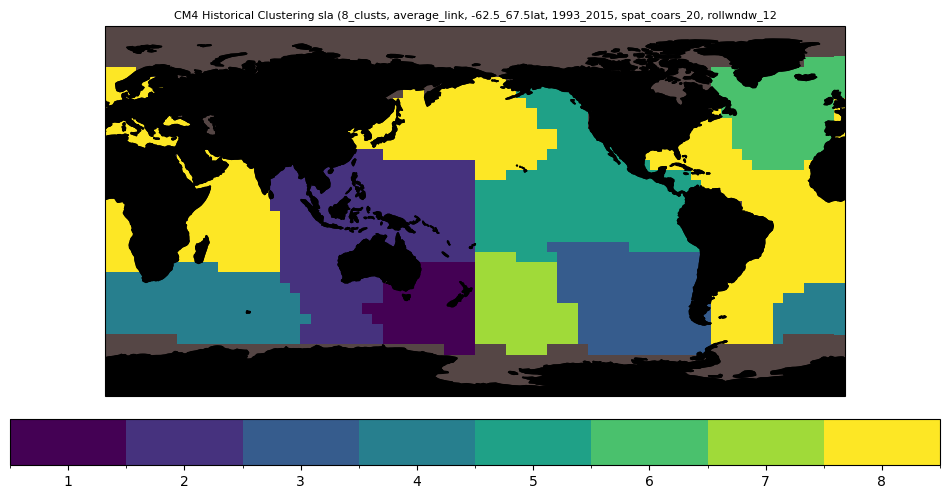

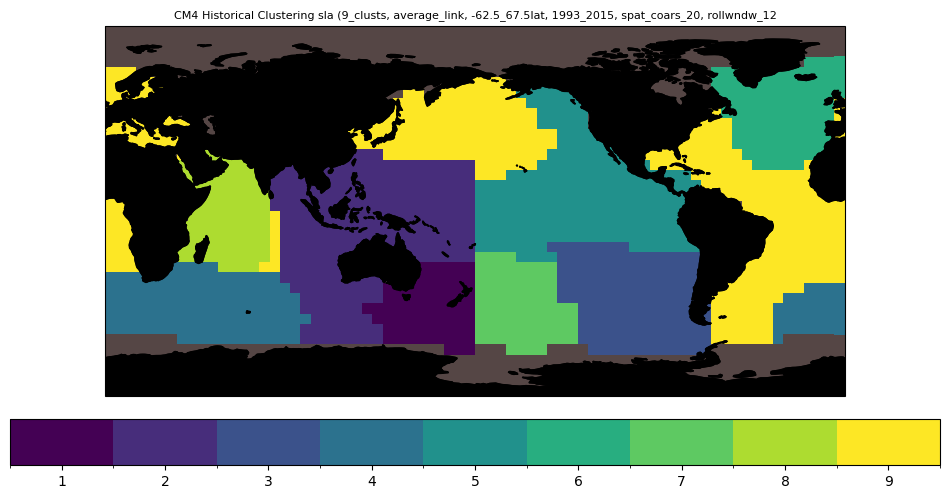

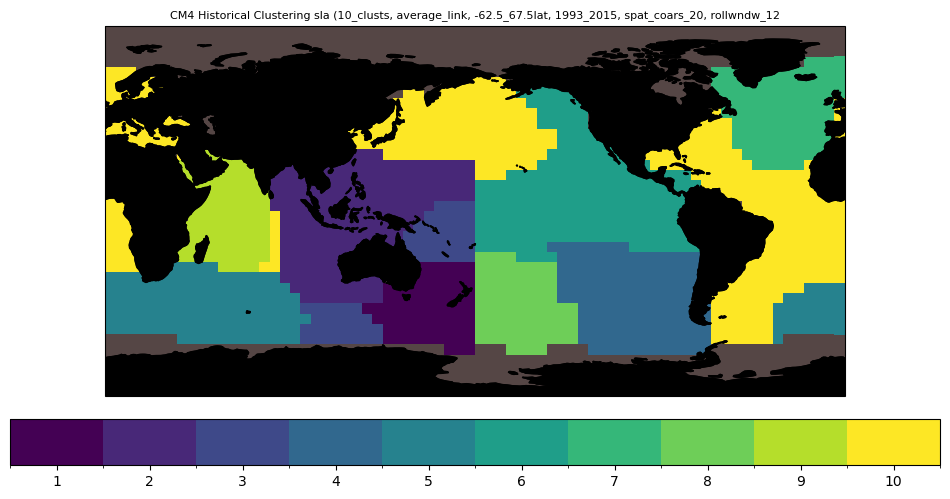

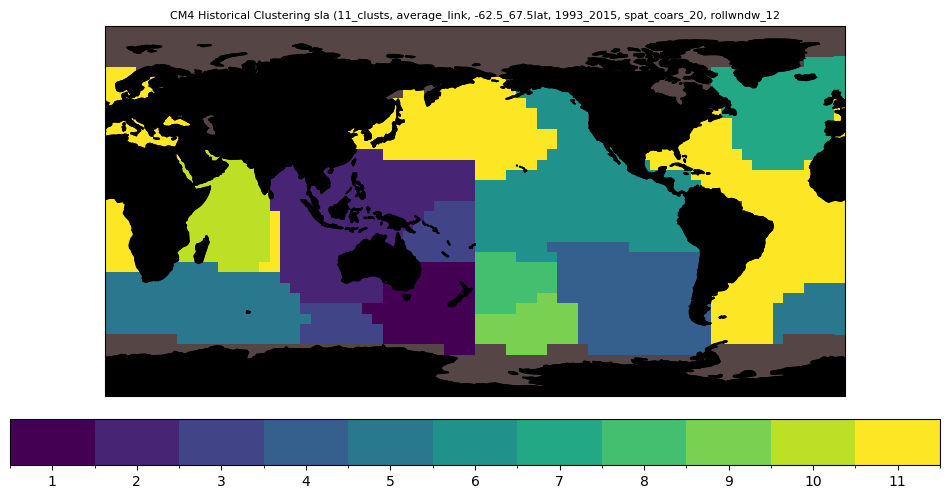

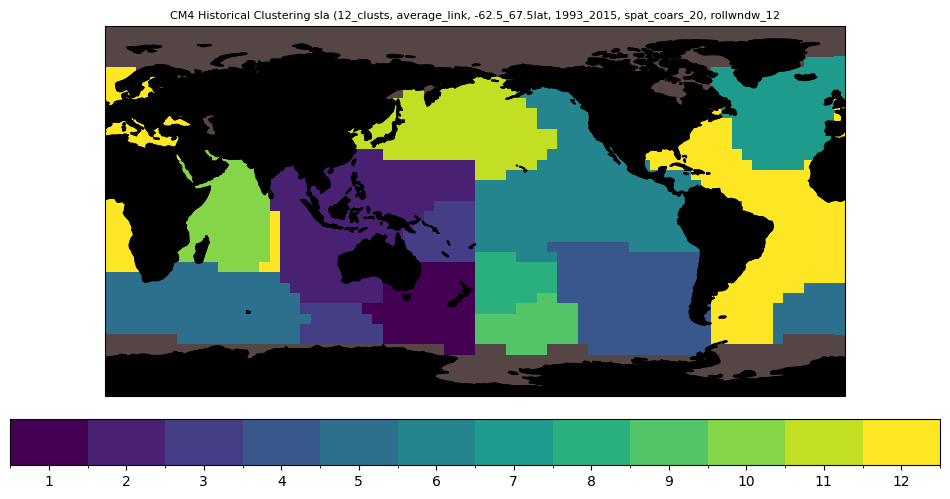

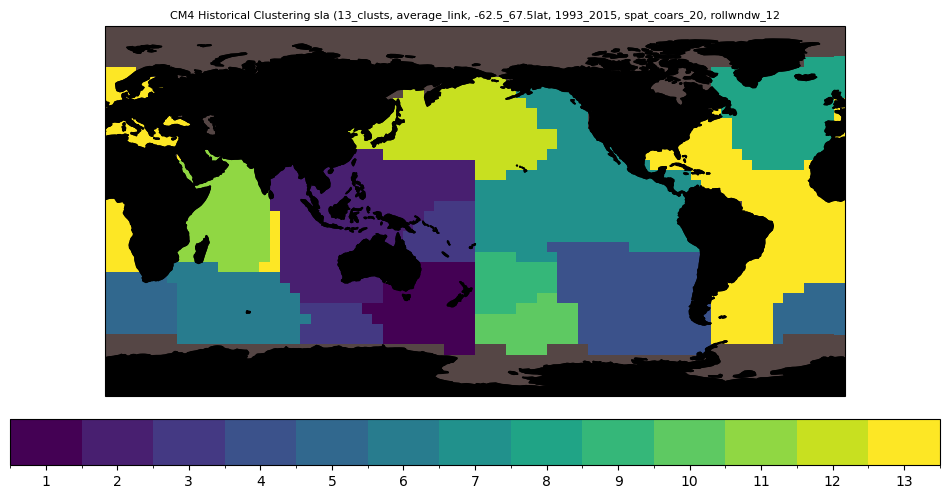

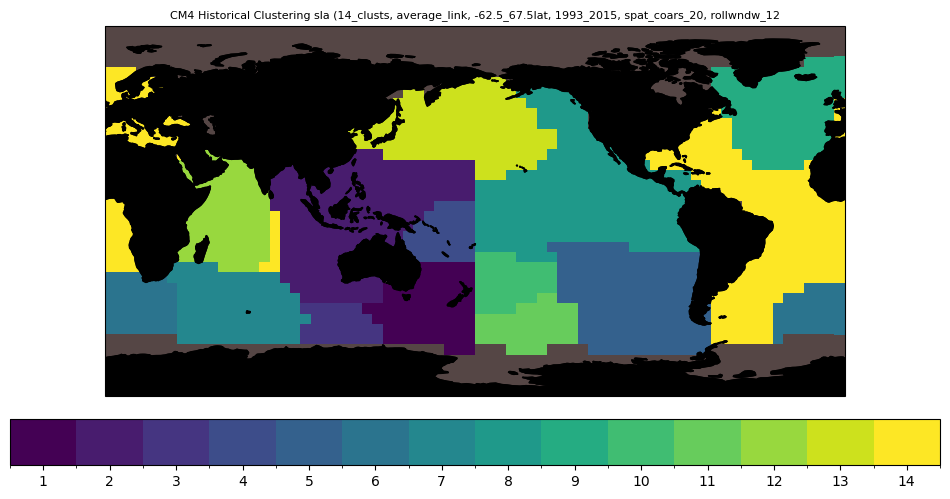

In [132]:
for num_clusters_it in num_clusters_arr:
    
    distance_matrix = comparison_matrix
    
    linkage_matrix = linkage(distance_matrix, method=linkage_type)
    
    # Extract the cluster labels
    cluster_labels = fcluster(linkage_matrix, num_clusters_it, criterion='maxclust')
    
    unique_labels = np.unique(cluster_labels)
    list_to_array_slicing = np.array(keys_for_indexing)
    
    for label in unique_labels:
        cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
        # in the code below when we index using 0 and 1 that is the array of the longitude and latitude coords. We must now put these into an xarray dataset.
        group_longitude = list_to_array_slicing[cluster_points, 1]
        group_latitude = list_to_array_slicing[cluster_points, 0]
    
        for point_iterator in range(len(group_latitude)):
            nan_dataset_to_fill.loc[{'longitude': group_longitude[point_iterator], 'latitude': group_latitude[point_iterator]}] = label
    from matplotlib.colors import ListedColormap, BoundaryNorm

    # Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
    sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
    center_value_longitude = 180
    sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude
    
    # Define the number of discrete values (clusters) you have
    
    # Create a discrete colormap
    cmap = plt.get_cmap('viridis', num_clusters_it)
    bounds = np.arange(1, num_clusters_it + 2) - .5
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Plotting the cluster map
    projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})
    
    # Plot the data
    sla_dataset_to_plot.zos.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)
    
    # Add title and extent
    ax.set_title(f'CM4 Historical Clustering sla ({num_clusters_it}_clusts, {linkage_type}_link, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spat_coars_{smoothing_std}, rollwndw_{rolling_window}', fontsize=8)
    ax.set_extent([-180, 180, -90, 90], crs=projection)
    
    # Add coastlines and features
    ax.coastlines(transform=projection)
    ax.add_feature(cfeature.LAND, zorder=10, color='black')
    ax.add_feature(cfeature.OCEAN, color='#554645')
    
    # Create colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_ticks(np.arange(1, num_clusters_it + 1))
    cbar.set_ticklabels(np.arange(1, num_clusters_it + 1))
    
    # Save the figure
    plt.savefig(f'model_maps/2_zos_vary_cluster/CM4_historical_zos_{linkage_type}_linkage_{num_clusters_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')


### Dendrogram 

/vftmp/Theo.Avila/pid4345/ipykernel_32195/1067750959.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend), truncate_mode='lastp')


Text(0.5, 1.0, 'Dendrogram CM4Hist average trunc (yr_1993_2015_spatialcoarse_20_tempsmooth_12)')

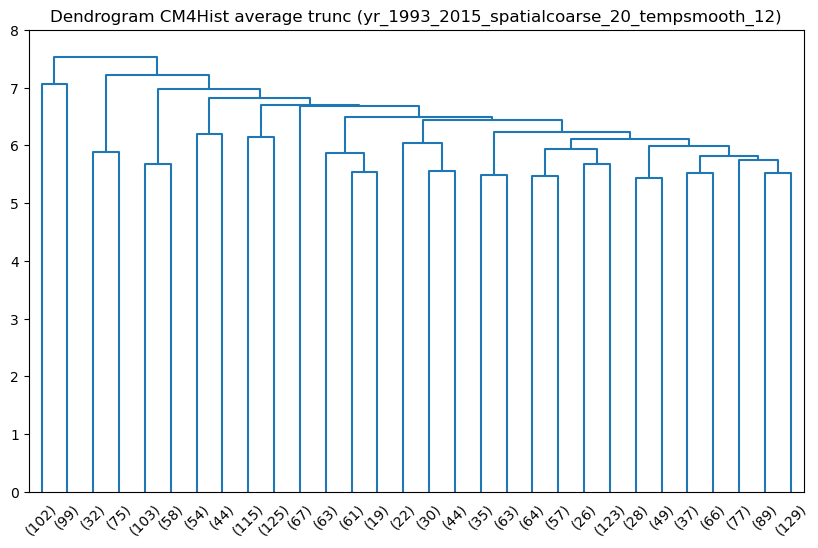

In [286]:
method_dend = 'average'

# Generate the dendrogram
dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend), truncate_mode='lastp')
plt.ylim(0, 8)

# Change the figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # Set the desired width and height

# Add a title
plt.title(f"Dendrogram CM4Hist {method_dend} trunc (yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window})")

# Show the dendrogram
#plt.savefig(f'model_maps/11_dendrograms/dendrogram_{method_dend}_yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window}.png')

### Masking

In [312]:
mask = nan_dataset_to_fill.copy(deep=True)

cmap = plt.get_cmap('viridis', len(unique_labels))
#figure = plt.figure(figsize=(10, 6))

# Grouping each cluster and plotting

each_cluster_dataset_true = []
each_cluster_dataset_false = []

for idx, cluster_val in enumerate(unique_labels):

    # Creating boolean based off of unique label, then applying so I have just the values for each cluster, could add to an array in order iterate through the others for covariance.
    boolean_mask_cluster = mask['sla'] == cluster_val
    cluster_i_masked_true = subset_Coarse_lat_lon_slice_initeration.where(boolean_mask_cluster).copy(deep=True)
    cluster_i_masked_false = subset_Coarse_lat_lon_slice_initeration.where(~boolean_mask_cluster).copy(deep=True)

    each_cluster_dataset_true.append(cluster_i_masked_true)
    each_cluster_dataset_false.append(cluster_i_masked_false)

    # Mean of each cluster in time from original. 
    #cluster_i_masked_mean = cluster_i_masked.mean(dim=['longitude', 'latitude'])
    #cluster_i_masked_mean.plot(label=f'cluster {cluster_val}', color=cmap(idx), linewidth=2)


#plt.legend()
#plt.show()

In [314]:
intra_cov_ar = []

for count, inv_cluster_true in enumerate(each_cluster_dataset_true):

    # INtra cluster variance
    da_flat_cov = inv_cluster_true.stack(location=('yh', 'xh')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov = da_flat_cov.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix = da_flattened_cov.to_pandas().T.cov().copy(deep=True)
    
    averaged_for_each_pt_cov = cov_matrix.mean(axis=0).copy(deep=True)
    da_flat_cov.load()
    # Unstack the data
    unstack_data = averaged_for_each_pt_cov.unstack().copy(deep=True)
    
    cluster_intra_cluster_filled = inv_cluster_true.mean(dim='time').copy(deep=True)
    cluster_intra_cluster_filled = cluster_intra_cluster_filled.fillna(np.nan)

    # Inner cluster variance now
    da_flat_cov_false = each_cluster_dataset_false[count].stack(location=('yh', 'xh')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov_false = da_flat_cov_false.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix_false = da_flattened_cov_false.to_pandas().T.copy(deep=True)
    da_flat_cov_false.load()
    
    for longitude in unstack_data.columns:
        # Iterate over the index values in "unstack_data"
        print(longitude)
        for latitude in unstack_data.index:
            
            # Access the specific cell in "intra_cov" using index and column values
            unstack_intra_cluster_cov = unstack_data.loc[latitude, longitude]

            unstack_data_values = da_flat_cov.loc[{'yh': latitude, 'xh': longitude}].values
            
            cov_matrix_false_copy_for_fill = cov_matrix_false.copy(deep=True)
            cov_matrix_false_copy_for_fill[latitude, longitude] = unstack_data_values
            cov_matrix_false_meaned = cov_matrix_false_copy_for_fill.cov().mean(axis=0)
            resultant_cov_denom_mean = cov_matrix_false_meaned[latitude, longitude]
            cluster_intra_cluster_filled.loc[latitude, longitude] = np.abs(unstack_intra_cluster_cov / resultant_cov_denom_mean)

    
    

            
    print(count)
    intra_cov_ar.append(cluster_intra_cluster_filled)

-36.764499187619755
-31.754654391282475
-26.752661435582365
-21.758091272300575
-16.770409666881005
-11.78899658716443
-6.813166898157752
-1.8421917496966258
3.124679941793768
8.088200491598181
13.049103466167457
18.00808522472692
22.965788437014616
27.92278797780159
32.87957953786772
37.83657122309745
42.794078337290806
47.75232146048912
0
-122.86839194666314
-117.7921124422384
-112.7116933347061
-107.6282469637305
-102.54295559493013
-97.45704440506985
-92.3717530362695
-87.28830666529392
-127.93951413958692
-82.20788755776161
-77.13160805333689
-138.06281495875186
-133.00457756974902
-72.0604858604131
1
-26.752661435582365
-21.758091272300575
-16.770409666881005
-11.78899658716443
-6.813166898157752
-51.8435086884062
-82.20788755776161
-77.13160805333689
-56.88639306201357
-87.28830666529392
-61.93718504124814
-92.3717530362695
-66.99542243025098
-46.80883227540832
-41.782502218363405
-36.764499187619755
-31.754654391282475
-72.0604858604131
-1.8421917496966258
2
-257.67143605013086

In [315]:

cmap_ar_div = []
matplot_color_array = ['forestgreen','gold', 'turquoise', 'orange', 'dodgerblue', 'mediumvioletred', 'peru', 'blue', 'indigo', 'violet', 'lightgreen', 'crimson', 'maroon', 'lightsalmon', 'powderblue']

for color_matplot in (matplot_color_array[0:num_clusters]):
    div_color = sns.light_palette(color_matplot, as_cmap=True)
    cmap_ar_div.append(div_color)

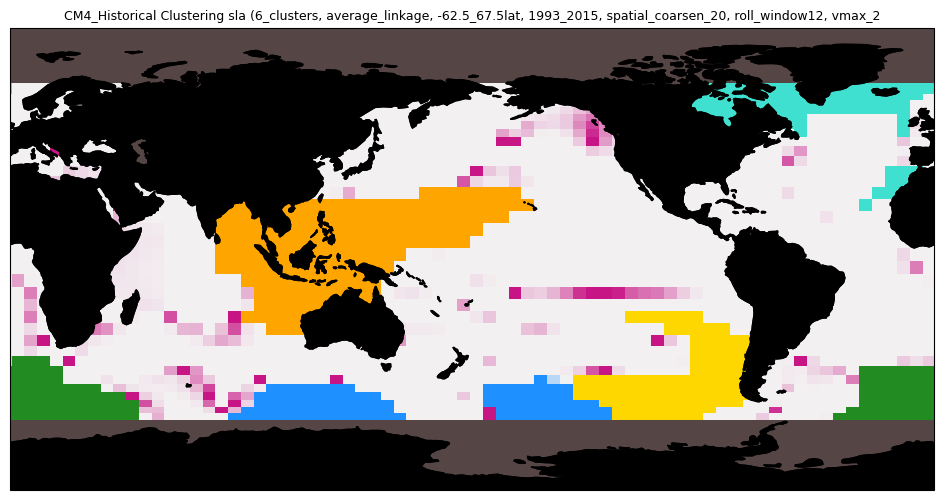

In [319]:
# Plotting the cluster map
center_value_longitude=180
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

vmax_val, vmin_val = 2, .5
for cmap_it, intra_cov in enumerate(intra_cov_ar):
    intra_cov['xh'] = intra_cov['xh'] - 180
    intra_cov.plot(ax=ax, transform=projection, cmap=cmap_ar_div[cmap_it], add_colorbar=False, vmax=vmax_val, vmin=vmin_val)
    #intra_cov['longitude'] = intra_cov['longitude'] + 180

# Add title and extent
ax.set_title(f'CM4_Historical Clustering sla ({num_clusters}_clusters, {linkage_type}_linkage, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spatial_coarsen_{smoothing_std}, roll_window{rolling_window}, vmax_{vmax_val}', fontsize=9)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar


# Save the figure
plt.savefig(f'model_maps/CM4_Historical_sla_{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}_intra_inner_cluster_covariance_vmax_{vmax_val}.png')

### Plot Test

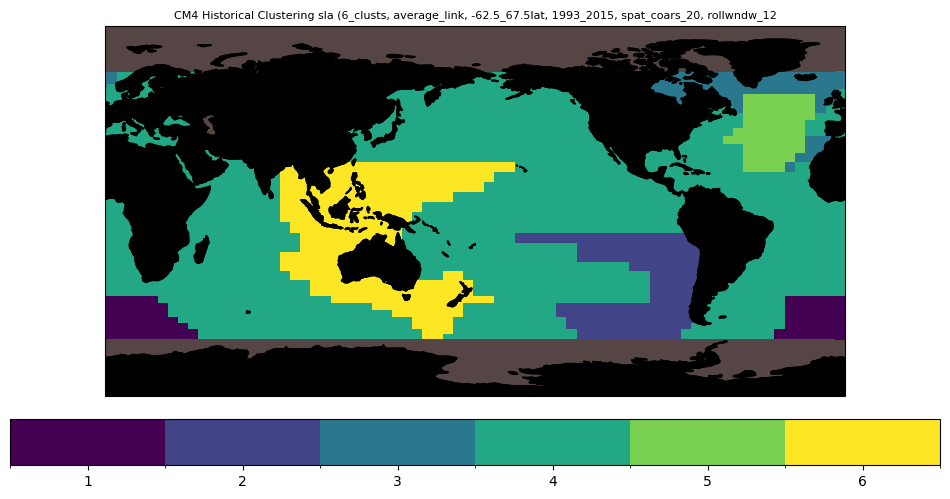

In [348]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
center_value_longitude = 180
sla_dataset_to_plot['xh'] = sla_dataset_to_plot['xh'] - center_value_longitude

# Define the number of discrete values (clusters) you have

# Create a discrete colormap
cmap = plt.get_cmap('viridis', num_clusters)
bounds = np.arange(1, num_clusters + 2) - .5
norm = BoundaryNorm(bounds, cmap.N)

# Plotting the cluster map
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

# Plot the data
sla_dataset_to_plot.sla.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)

# Add title and extent
ax.set_title(f'CM4 Historical Clustering sla ({num_clusters}_clusts, {linkage_type}_link, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spat_coars_{smoothing_std}, rollwndw_{rolling_window}', fontsize=8)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
cbar.set_ticks(np.arange(1, num_clusters + 1))
cbar.set_ticklabels(np.arange(1, num_clusters + 1))

# Save the figure
#plt.savefig(f'model_maps/CM4_historical_sla_{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')


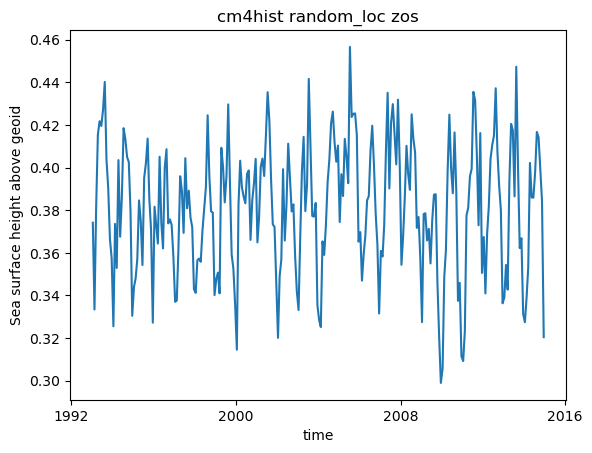

In [293]:
ds = xr.open_zarr(file_path)
ds = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-05-31"))
#da_gm = subset.sla.weighted(subset.areacello * subset.wet).mean(('yh', 'xh'))
#subset['sla'] = subset.sla - da_gm
ds.zos.sel(xh=200, yh=0, method='nearest').plot()
plt.title('cm4hist random_loc zos')
plt.savefig('model_maps/0_steps_cm4hist_random_loc_zos.png')